# **Title: Comparison of Data Mining and Natural Language Processing Techniques for Crash Analysis**

1.	**GRU_Word2Vec_Unbalanced** 
3.	**GRU_Word2Vec_Balanced_Pos**
4.	**LSTM_Word2Vec_Balanced**
5.	**LSTM_Word2Vec_Unbalanced**
6.	**LSTM_Word2Vec_Balanced_Pos**
7.	**SVM_CF_Unbalanced**
8.	**SVM_CF_Balanced_Pos**
9.	**LGR_CF Balanced**
10.	**Bigram NoisyOR**

**Bigram NoisyOR**



* Word2Vec=Pretrained GoogleNews-vectors-negative300
* Balanced= keep all the workzone crashes and pull same amount of non workzone crashes from random sampling
*Pos = keep only the sentances which has positive unigram onky from **Unigram- NoisyOR**















In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



# **Dependencies**



In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding,LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
import string
import nltk
import math
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import os

Using TensorFlow backend.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Load google word-embedding**


In [3]:
from gensim.models import KeyedVectors
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
word2vec_model = KeyedVectors.load_word2vec_format('/content/drive/My Drive/New/GoogleNews-vectors-negative300.bin', binary=True)

2020-06-15 06:52:59,936 : INFO : loading projection weights from /content/drive/My Drive/New/GoogleNews-vectors-negative300.bin
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-06-15 06:54:14,777 : INFO : loaded (3000000, 300) matrix from /content/drive/My Drive/New/GoogleNews-vectors-negative300.bin


# **Data porcessing**

Write a function to rpocess the data

In [0]:
def clean_doc(textlist):
    #list to store the clean data
    output=[]
    #read by narratives.Here,  A narrative is a string of multiple sentences.
    for doc in textlist:
        # make all lower case
        doc=doc.lower()
        # create temporary token
        tokens=doc.split()
        # remove all punctuation
        table=str.maketrans('','',string.punctuation)
        tokens=[w.translate(table) for w in tokens]
        # remove numeric values
        tokens1=[word for word in tokens if word.isalpha()]
        # remove stop words
        stop_words=set(stopwords.words('english'))
        tokens2=[w for w in tokens1 if not w in stop_words]
        # remove words which has <= 2 characters
        tokens3=' '.join([word for word in tokens2 if len(word)>=2]) 
        # return the clean sentance again 
        output.append(tokens3)
    return output

Call the data to process

> Trainning data 2017-2018 which includes reported WZ and NWZ. WZ=1 and NWZ=0.


1.   Delete all records that has null values in construction and narrative columns
2.   Format date field for data analysis





In [0]:
# Train and Test file name
trainFile='/content/drive/My Drive/New/Train_raw_data/TrainingDataSet_Balanced.csv' 
testFile='/content/drive/My Drive/New/Train_raw_data/Random_200_Manual Review_WZ_NWZ_6_10.csv'      
# which is consisted of 2017-2018 WZ and NWZ (balanced data)
traindf=pd.read_csv(trainFile)
# drop null rows as it will results error in classifying algorithm.
traindf=traindf.dropna(subset=['CONSZONE','OFFRNARR'])


Clean the data and Prepare train and test data

In [19]:
######  Train data
# no need. you can use it for result analysis, or make query by data
'''traindf['CRSHDATE']=pd.to_datetime(traindf['CRSHDATE'])'''
# use only the narrative as train data and make it a list/arrary
x_train_text=traindf["OFFRNARR"].values
x_train_tok=traindf[traindf.CONSZONE==1]["OFFRNARR"].values
# print a narrative before data cleaning
print ("Before Data cleaning:\n", x_train_text[0])
#clean the data
x_train_text=clean_doc(x_train_text)
x_train_tok=clean_doc(x_train_tok)
# print the clean data
print ("After Data cleaning:\n",x_train_text[0])
# it was y as conszone in the field. but here, this data has conszone (WZ) with Y=1, and Null=0=NWZ. It was done before calling it here.
y_train_text=traindf["CONSZONE"].values

######  Test data
#test data consists of 2019 dataset, for our case it is only NWZ part of 2019 
testdf=pd.read_csv(testFile)
# drop null rows as it will results error in classifying algorithm.
testdf=testdf.dropna(subset=['CONSZONE','OFFRNARR'])
testdf.to_csv('test2019.csv',index=None)
# do the same for test data
x_test_text=testdf["OFFRNARR"].values
x_test_text=clean_doc(x_test_text)
y_test_text=testdf["Manual_Review"].values
print(y_test_text.shape)
# print number of narratives fro train and test
print (len(x_train_text),len(x_test_text),len(x_train_tok))

Before Data cleaning:
 eb i at sth  s th st on ramp  squad arrived and found a two car pdo  operator of unit  stated that he was traveling east in the left lane and the vehicle in front of him stopped suddenly  operator of unit one stated i braked and my antilock brakes activated and i hit the car in front of me  operator of unit two stated that he was traveling east in the left lane on i and traffic in front of him came to a stop so he slowed down and the truck behind him hit him  upon investigation units one and two were traveling east on i just under the hwy  overpass  unit two slowed due to traffic congestion and unit one struck unit two in the rear  no witness  no tows

After Data cleaning:
 eb sth th st ramp squad arrived found two car pdo operator unit stated traveling east left lane vehicle front stopped suddenly operator unit one stated braked antilock brakes activated hit car front operator unit two stated traveling east left lane traffic front came stop slowed truck behind h

# **Tokenization and word vectorization**

In [101]:
# Apply tokenizer on the train data only. it will create words/tokens from train data only. so any new words in test data will be converted into 0 and be used as padding value
tokenizer=Tokenizer(num_words=None)
tokenizer.fit_on_texts(x_train_tok)
count_thres = 1000

low_count_words = [w for w,c in tokenizer.word_index.items() if c < count_thres]          
for w in low_count_words:
  del tokenizer.word_index[w]
x_train_tokk=tokenizer.texts_to_sequences(x_train_tok)
x_train_tokens=tokenizer.texts_to_sequences(x_train_text)
x_test_tokens=tokenizer.texts_to_sequences(x_test_text)
num_tokens=[len(tokens) for tokens in x_train_tokk]
num_tokens=np.array(num_tokens)
max_tokens=np.max(num_tokens)
max_tokens_3std = math.ceil(np.mean(num_tokens) + 3* np.std(num_tokens))
pad='post'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens_3std,padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens_3std,padding=pad, truncating=pad)
print(x_train_pad[10])


[3671 1984 1985 1453 3672 3673 1592 1986 1592 2748    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


Analyze the length of vector as well as Narrative length to decide the vector length

In [0]:
num_tokens=[len(tokens) for tokens in x_train_tokens]
num_tokens=np.array(num_tokens)
max_tokens=np.max(num_tokens)
print ("maximum Narrative length after data cleaning:",max_tokens)
max_tokens_3std = math.ceil(np.mean(num_tokens) + 3* np.std(num_tokens))
print ("average Narrative length at 3rd STD after data cleaning:", max_tokens_3std)


maximum Narrative length after data cleaning: 216
average Narrative length at 3rd STD after data cleaning: 154


Apply the 3rd STD value as the maximum narrative length.

In [0]:
# to apply fixed sequence length, pad with 0 at the beginning of sequence
pad='post'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens_3std,padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens_3std,padding=pad, truncating=pad)
#print(x_train_pad)
# next apply classification algorithm.

[[  60    7 1645 ...    0    0    0]
 [   1   21    7 ...    0    0    0]
 [   4    6   16 ...    0    0    0]
 ...
 [   1    9    2 ...    0    0    0]
 [   1    7  119 ...    0    0    0]
 [   1    7   53 ...    0    0    0]]


Write functions to apply word embedding. NUM_WORDS is the length of embedding vector. As we are using Google word-embeding, i chose a value of 300. Added 1 to store the dimensions for the words for which no pretrained word embeddings exist

In [66]:
num_words=len(tokenizer.word_index)+300
def getVector(str):
 if str in word2vec_model:
  return word2vec_model[str]
 else:
  return None;
def isInModel(str):
  return str in word2vec_model

embedding_size=300
embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i>=embedding_size:
        continue
    try:
        #print(word)
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),embedding_size)
print(embedding_matrix[6514])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [67]:
model=Sequential()
model.add(Embedding(input_dim=num_words,output_dim=embedding_size,input_length=max_tokens_3std,name='layer_embedding',weights=[embedding_matrix],trainable=False))
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=32))
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
mc = ModelCheckpoint('best_model'+str('TopFrequency')+'model_name'+'.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10)
model.fit(x_train_pad, y_train_text,validation_split=0.15, epochs=80, batch_size=32, callbacks=[es,mc])

Epoch 1/80
148/148 [==============================] - ETA: 0s - loss: 0.6786 - accuracy: 0.5849
Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to best_modelTopFrequencymodel_name.hdf5
148/148 [==============================] - 14s 93ms/step - loss: 0.6786 - accuracy: 0.5849 - val_loss: 0.8633 - val_accuracy: 0.0000e+00
Epoch 2/80
148/148 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.5881
Epoch 00002: val_accuracy did not improve from 0.00000
148/148 [==============================] - 13s 89ms/step - loss: 0.6775 - accuracy: 0.5881 - val_loss: 0.8437 - val_accuracy: 0.0000e+00
Epoch 3/80
148/148 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.5885
Epoch 00003: val_accuracy did not improve from 0.00000
148/148 [==============================] - 13s 90ms/step - loss: 0.6768 - accuracy: 0.5885 - val_loss: 0.8353 - val_accuracy: 0.0000e+00
Epoch 4/80
148/148 [==============================] - ETA: 0s - loss: 0.6756 - a

# **Develop the Deep Learning Model**


1.   num_words is the length of vocabulary
2.   List item



In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
import operator
def plot_roc(clf,model_name, y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr,label=model_name+': ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
   
def print_scores(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('F1 score: {:3f}'.format(f1_score(y_test, y_pred)))
    print('AUC score: {:3f}'.format(roc_auc_score(y_test, y_pred)))

def vectorizebyCount(text, maxx_features):
    cv = CountVectorizer(max_features=maxx_features, stop_words='english')    
    countWord = cv.fit_transform(text)
    #index_value={i[1]:i[0] for i in cv.vocabulary_.items()}    
    #print (dict(sorted(index_value.items(), key=operator.itemgetter(0),reverse=True)))
    return cv,countWord

#optimizer = Adam(lr=1e-3)

def evaluation(model_name_list, x_trains,y_trains, x_tests,y_tests,test_split,test_file_df,TopFrequency):
    outputdf=test_file_df.copy()
    #for model_name in model_name_list:
     # outputdf[model_name]=np.NaN
    
    validation=int(y_test_text.shape[0]*.15) 
    tempList=[999]*validation   
    plt.figure(figsize=(10,5))
    
    for model_name in model_name_list: 
      
      cv,X = vectorizebyCount(x_trains,TopFrequency)
      tx=cv.transform(x_tests)
      x_train, x_test, y_train, y_test= X,tx,y_trains,y_tests
      #x_train, x_test, y_train, y_test= X,tx[validation:],y_trains,y_tests[validation:]
  
      if model_name=='LGR':  
          clf = LogisticRegression(random_state=0).fit(x_train, y_train)
          y_pred = clf.predict_proba(x_test)
          y_pred=[i[1] for i in y_pred ] 
          tn, fp, fn, tp=confusion_matrix(y_test, clf.predict(x_test)).ravel()
          
          outputdf[model_name]=np.array(y_pred)
          #outputdf[model_name]=np.array(tempList+y_pred)
          print("tn, fp, fn, tp",tn, fp, fn, tp)           
          #resultList.append([y_test,y_pred])
          plot_roc(clf,model_name, y_test,y_pred)          
          print (model_name+" done")
      elif model_name=='NB': 
          x_train,x_test=x_train.toarray(), x_test.toarray()
          clf= GaussianNB().fit(x_train, y_train)   
          y_pred=clf.predict_proba(x_test)
          y_pred=[i[1] for i in y_pred ] 
          tn, fp, fn, tp=confusion_matrix(y_test, clf.predict(x_test)).ravel()
          outputdf[model_name]=np.array(y_pred)
          #outputdf[model_name]=np.array(tempList+y_pred)
          print("tn, fp, fn, tp",tn, fp, fn, tp) 
         # resultList.append([i[1] for i in pr])
          plot_roc(clf,model_name, y_test,y_pred)
          print (model_name+" done")
          
  
      elif model_name=='SVC': 
          clf= SVC(kernel='linear',probability=True).fit(x_train, y_train)   
          y_pred=clf.predict_proba(x_test)
          y_pred=[i[1] for i in y_pred ] 
          tn, fp, fn, tp=confusion_matrix(y_test, clf.predict(x_test)).ravel()
          outputdf[model_name]=np.array(y_pred)
          #outputdf[model_name]=np.array(tempList+y_pred)
          print("tn, fp, fn, tp",tn, fp, fn, tp) 
         # resultList.append([i[1] for i in pr])
          plot_roc(clf,model_name, y_test,y_pred)          
          print (model_name+" done")
  
      elif model_name=='RF':
          clf= RandomForestClassifier().fit(x_train, y_train)          
          y_pred=clf.predict_proba(x_test)
          y_pred=[i[1] for i in y_pred ] 
          tn, fp, fn, tp=confusion_matrix(y_test, clf.predict(x_test)).ravel()
          outputdf[model_name]=np.array(y_pred)
          #outputdf[model_name]=np.array(tempList+y_pred)
          print("tn, fp, fn, tp",tn, fp, fn, tp)          
         # resultList.append([i[1] for i in pr])
          plot_roc(clf,model_name, y_test,y_pred)
          
          print (model_name+" done")
      elif model_name=='Knn':
          clf= KNeighborsClassifier(n_neighbors=8).fit(x_train, y_train)
          y_pred=clf.predict_proba(x_test)
          y_pred=[i[1] for i in y_pred ] 
          tn, fp, fn, tp=confusion_matrix(y_test, clf.predict(x_test)).ravel()
          outputdf[model_name]=np.array(y_pred)
          #outputdf[model_name]=np.array(tempList+y_pred)
          print("tn, fp, fn, tp",tn, fp, fn, tp)    
          #resultList.append([i[1] for i in pr])
          #resultList.append(clf.predict(x_test))
          plot_roc(clf,model_name, y_test,y_pred)
          #skplt.metrics.plot_roc_curve(y_test,pr)
          #plt.show()
          
          print (model_name+" done")
      elif model_name=="GRU":
          tokenizer=Tokenizer(num_words=None)
          tokenizer.fit_on_texts(['constructions','zoo'])
          count_thres = 2
          '''low_count_words = [w for w,c in tokenizer.word_counts.items() if c < count_thres]          
          for w in low_count_words:
            del tokenizer.word_index[w]'''
          low_count_words = [w for w,c in tokenizer.word_index.items() if c < count_thres]          
          for w in low_count_words:
            del tokenizer.word_index[w]
            del tokenizer.word_docs[w]
            del tokenizer.word_counts[w]
          x_train_tokk=tokenizer.texts_to_sequences(x_train_tok)
          x_train_tokens=tokenizer.texts_to_sequences(x_trains)
          x_test_tokens=tokenizer.texts_to_sequences(x_tests)
          num_tokens=[len(tokens) for tokens in x_train_tokk]
          num_tokens=np.array(num_tokens)
          max_tokens=np.max(num_tokens)
          #max_tokens_3std = math.ceil(np.mean(num_tokens) + 3* np.std(num_tokens))
          pad='post'
          x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,padding=pad, truncating=pad)
          x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,padding=pad, truncating=pad)
          num_words=len(tokenizer.word_index)+5
          print(num_words)
          embedding_size=300
          embedding_matrix = np.zeros((num_words, embedding_size))
          for word, i in tokenizer.word_index.items():
              if i>=embedding_size:
                  continue
              try:
                  #print(word)
                  embedding_vector = word2vec_model[word]
                  embedding_matrix[i] = embedding_vector
              except KeyError:
                  embedding_matrix[i]=np.random.normal(0,0,embedding_size)
          model=Sequential()
          model.add(Embedding(input_dim=num_words,output_dim=embedding_size,input_length= max_tokens,name='layer_embedding',weights=[embedding_matrix],trainable=False))
          model.add(GRU(units=32, return_sequences=True))
          model.add(GRU(units=32))
          model.add(Dense(1, activation='sigmoid'))    
          model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
          mc = ModelCheckpoint('best_model'+str(TopFrequency)+model_name+'.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
          es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10)
          model.fit(x_train_pad, y_trains,validation_split=0.15, epochs=80, batch_size=32, callbacks=[es,mc])
          #model.fit(x_train_pad, y_trains,validation_data=(x_test_pad[:validation], y_tests[:validation]), epochs=80, batch_size=32, callbacks=[es,mc])
          y_pred=model.predict(x_test_pad)
          #y_pred=model.predict(x_test_pad[validation:])
          pr=[1 if i>0.5 else 0 for i in y_pred]
          tn, fp, fn, tp=confusion_matrix(y_tests, pr).ravel()
          #tn, fp, fn, tp=confusion_matrix(y_tests[validation:], pr).ravel()
          #print((tempList)+[i for i in y_pred])
          outputdf[model_name]=np.array([i[0] for i in y_pred])
          #outputdf[model_name]=np.array(tempList+[i[0] for i in y_pred])
          print("tn, fp, fn, tp",tn, fp, fn, tp) 
          plot_roc(model,model_name, y_tests,y_pred)
          #plot_roc(model,model_name, y_tests[validation:],y_pred)
          print (model_name+" done")   
      else:
        print  ("Warning!!The {} model has not been developed yet.".format(model_name))
    
    
    #outputdf.to_csv('test_prediction_TopFrequency('+str(TopFrequency)+').csv',index=False)
      



6
Epoch 1/80
147/148 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.5869
Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to best_model500GRU.hdf5
148/148 [==============================] - 2s 14ms/step - loss: 0.6698 - accuracy: 0.5877 - val_loss: 0.8784 - val_accuracy: 0.0000e+00
Epoch 2/80
144/148 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.5894
Epoch 00002: val_accuracy did not improve from 0.00000
148/148 [==============================] - 1s 10ms/step - loss: 0.6670 - accuracy: 0.5881 - val_loss: 0.8667 - val_accuracy: 0.0000e+00
Epoch 3/80
145/148 [============================>.] - ETA: 0s - loss: 0.6674 - accuracy: 0.5866
Epoch 00003: val_accuracy did not improve from 0.00000
148/148 [==============================] - 1s 10ms/step - loss: 0.6670 - accuracy: 0.5881 - val_loss: 0.8818 - val_accuracy: 0.0000e+00
Epoch 4/80
145/148 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.5888
E

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


tn, fp, fn, tp 105 59 2 34
LGR done
tn, fp, fn, tp 112 52 2 34
RF done
tn, fp, fn, tp 104 60 13 23
Knn done


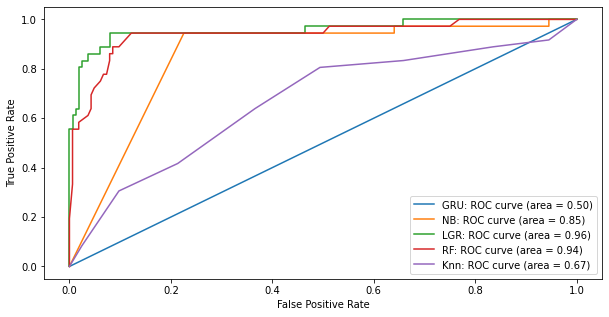

In [115]:
modelname_list=['GRU','NB','LGR','RF','Knn']
evaluation(modelname_list, x_train_text,y_train_text,x_test_text,y_test_text,0.15,testdf,500)

In [0]:
m=testdf.copy()
m

0.7885747085749726


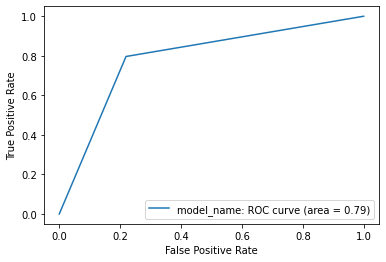

In [0]:
#x=df3.OFFRNARR.values
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
#cv = TfidfVectorizer(max_features=300)
#X = cv.fit_transform(x_train_text)

cv = TfidfVectorizer(max_features=5000)    
X = cv.fit_transform(x_train_text)
tx=cv.transform(x_test_text)
d=cv.transform(x_train_text).toarray()
x_train, x_test, y_train, y_test= X.toarray(),tx.toarray(),y_train_text,y_test_text
#print(x_train[0], d[0])
clf =LogisticRegression().fit(x_train, y_train)
#pred = cross_val_predict(clf, x_test, y_test, cv=3, n_jobs=4)  
pr=clf.predict(x_test)
#pr=[i[1]for i in pr]
results=confusion_matrix(y_test, clf.predict(x_test))          
print(roc_auc_score(y_test, pr))
plot_roc(clf,'model_name', y_test,pr)
#skplt.metrics.plot_roc_curve(y_test,pr)
#plt.show()

In [85]:
m={'a':1,'b':2,'c':3,'d':4,'e':5}
n=max(m.values())
for j,i in m.items():
  if i>2 and i<max(m.values()):
    print(i)
print(np.random.normal(0,0,embedding_size))

3
4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
